In [1]:
import sys, importlib
sys.path.append('../../')

from src.Modules.Utils.Imports import *

from src.get_params import get_heterog_LHC_params, get_adhesion_params_Padh_interpolation_Pm_fixed, get_adhesion_params_Pm_Padh_interpolation
import numpy.matlib as matlib

import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import DE_sim, simple_adhesion_diffusion, simple_pulling_diffusion
import matplotlib.patches as mpatches

device = torch.device(GetLowestGPU(pick_from=[0]))

from src.custom_functions import to_torch, to_numpy, load_model, recover_binn_params, unique_inputs

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fontsize = 24

def plot_sol_data(x,t,T,sol_MF=None,sol_BINN=None,sol_interp=None,zoom=None, filename=None, params=None):
    
    """
    Plot PDE simulation results against ABM data. This allows for comparison 
    between Mean-field PDE, BINN-guided PDE, and Interpolated PDE simulations 
    with ABM data.

    Parameters:
        x (np.ndarray): Spatial grid points.
        t (np.ndarray): Time points.
        T (np.ndarray): ABM data
        sol_MF (np.ndarray, optional): Mean-field PDE solution. Defaults to None.
        sol_BINN (np.ndarray, optional): BINN-guided PDE solution. Defaults to None.
        sol_interp (np.ndarray, optional): Interpolated PDE solution. Defaults to None.
        zoom (tuple, optional): Zoom-in coordinates for the last plot. Defaults to None.
        filename (str, optional): File name to save the generated figure. Defaults to None.
        params (tuple, optional): Model parameters for the title. Defaults to None.

    Returns:
        fig: A matplotlib figure.
        axes: An array of axes for each plot.
    """
    
    if zoom is None:
        fig, axes = plt.subplots(1,3,figsize=(18,6),layout='constrained')
        snapshots = [33,66,99]
    else:
        fig, axes = plt.subplots(1,4,figsize=(24,6),layout='constrained')
        snapshots = [33,66,99,99]

    count = 0
    for i in snapshots:
        if sol_MF is not None:
            axes[count].plot(x,sol_MF[:,i],"-", linewidth=8,  c = colors[0], label = "Mean-field PDE")
        if sol_BINN is not None:
            axes[count].plot(x,sol_BINN[:,i],"--",linewidth=5, c = colors[1], label = "BINN-guided PDE")
        if sol_interp is not None:
            axes[count].plot(x,sol_interp[:,i],".-",linewidth=5, c = colors[2], label = "Interpolated PDE")
        
        
        if i <= 75: #Training data
            m = "o" 
            mcolor = "black"
        else: #Testing data
            m ="s"
            mcolor = (.4,.4,.4)
        axes[count].plot(x[::2],T[::2,i],m,color=mcolor,markersize=8,label="Data")

        axes[count].set_xlabel("Space ($x$)",fontsize=fontsize)
        if count ==0: axes[count].set_ylabel("Density",fontsize=fontsize)
        axes[count].set_title(f"t = {round(t[i],1)}",fontsize=fontsize)
        count+=1
    
    if "simple_pulling" in filename:
        title = "Pulling ABM, $r_m^{pull}$ = "+f"{params[0]}"+", $p_{pull}$ = " + f"{params[1]}"
    elif "simple_adhesion" in filename:
        title = "Adhesion ABM, $r_m^{adh}$ = "+f"{params[0]}"+", $p_{adh}$ = " + f"{params[1]}"
    elif "adhesion_pulling" in filename:
        title = ("Pulling & Adhesion ABM, $r_m^{pull}$ = "+f"{params[0]}"+
                 ", $r_m^{adh}$ = "+f"{params[1]}"+
                 ", $p_{pull}$ = " + f"{params[2]}"+
                 ", $p_{adh}$ = " + f"{params[3]}"+
                 r", $\alpha$ = " + f"{params[4]}")
    plt.suptitle(title,fontsize=fontsize)
    if zoom is not None:    
        #zoom = (x,y,dx,dy)
        x,y,dx,dy = zoom
        
        rect=mpatches.Rectangle((x,y),dx,dy, 
                        fill = False,
                        color = "black",
                        linewidth = 1)
        axes[2].add_patch(rect)
        
        axes[3].set_xlim([x,x+dx])
        axes[3].set_ylim([y,y+dy])
        axes[3].set_xlabel("")
        axes[3].set_ylabel("")
        axes[3].set_title("")
        axes[3].set_xticks([])
        axes[3].set_yticks([])
        
    if filename is not None:
        plt.savefig(f"../../results/figures/{filename}.png",format="png")
    
    return fig, axes

Device set to cpu
Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Pulling ABM

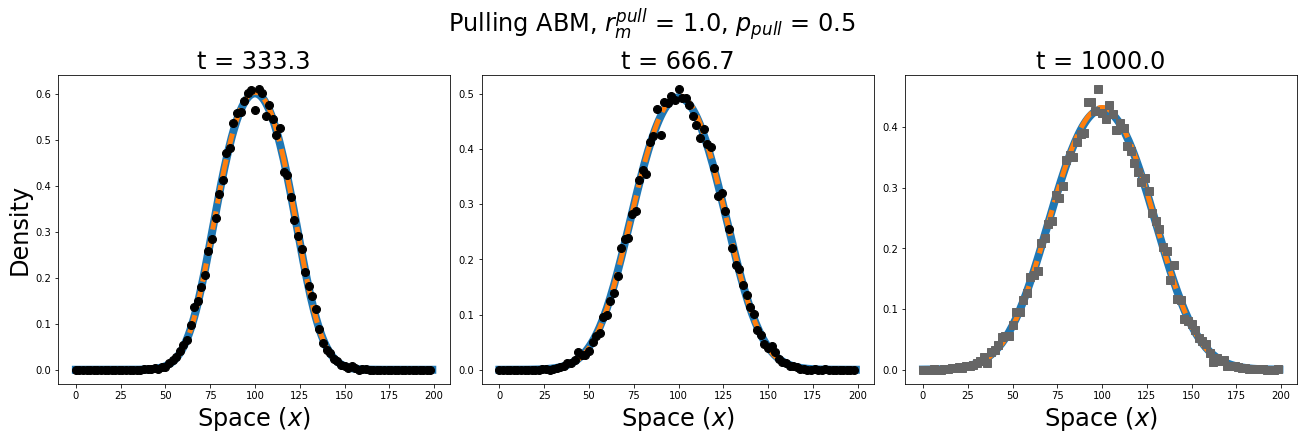

In [7]:
path = '../../data/'

### simulation 1
rmp, Ppull = 1.0, 0.8
zoom = None

### simulation 2
#Pm, Ppull = 0.9, 0.5
#zoom = None

params = (rmh, Ppull)
filename_header = f"simple_pulling_mean_25"

### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_Pm_{rmh}_Ppull_{Ppull}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC = outputs[:,0]

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']

q = [rmp/4, Ppull]
MF_PDE = DE_sim(x, t, q, IC, simple_pulling_diffusion)

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params = params)

## Adhesion ABM

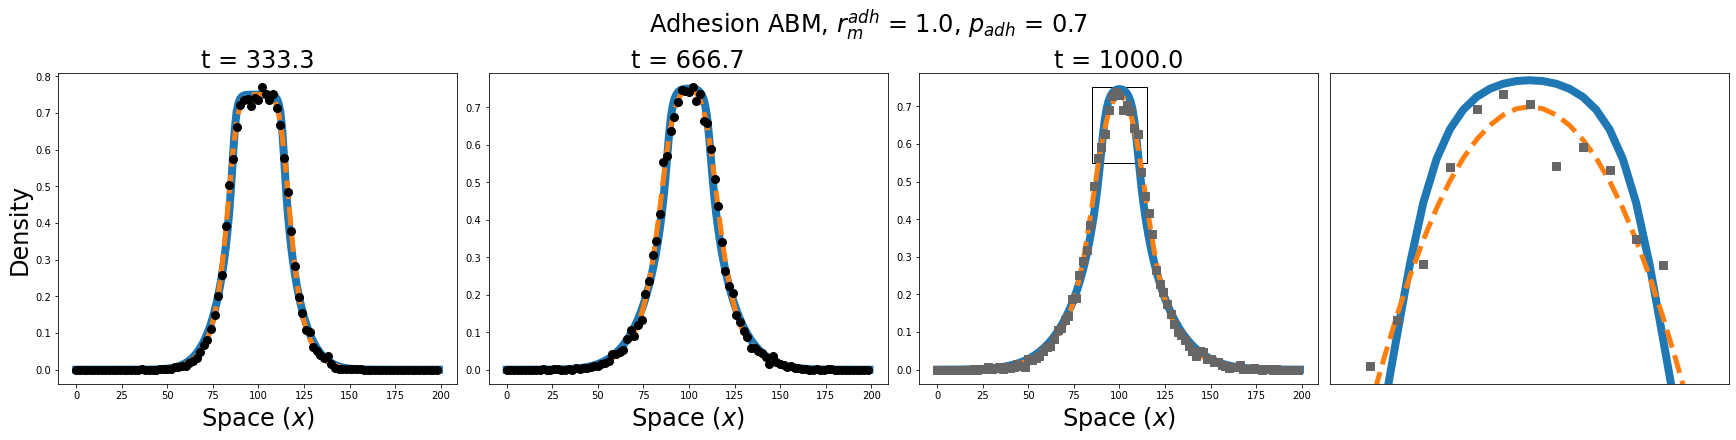

In [12]:
path = '../../data/'

### Simulation 1
rmh, Padh = 1.0, 0.7
zoom = (85, .55, 30,  .2)

### Simulation 2
#rmh, Padh = 0.1, 0.5
#zoom = None

params = (rmh, Padh)
filename_header = f"simple_adhesion_mean_25"

### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC = outputs[:,0]

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']

if Padh > 0.75:
    MF_PDE = None
else:
    q = [rmh/4, Padh]
    MF_PDE = DE_sim(x, t, q, IC, simple_adhesion_diffusion)

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params=params)

## Pulling Adhesion ABM

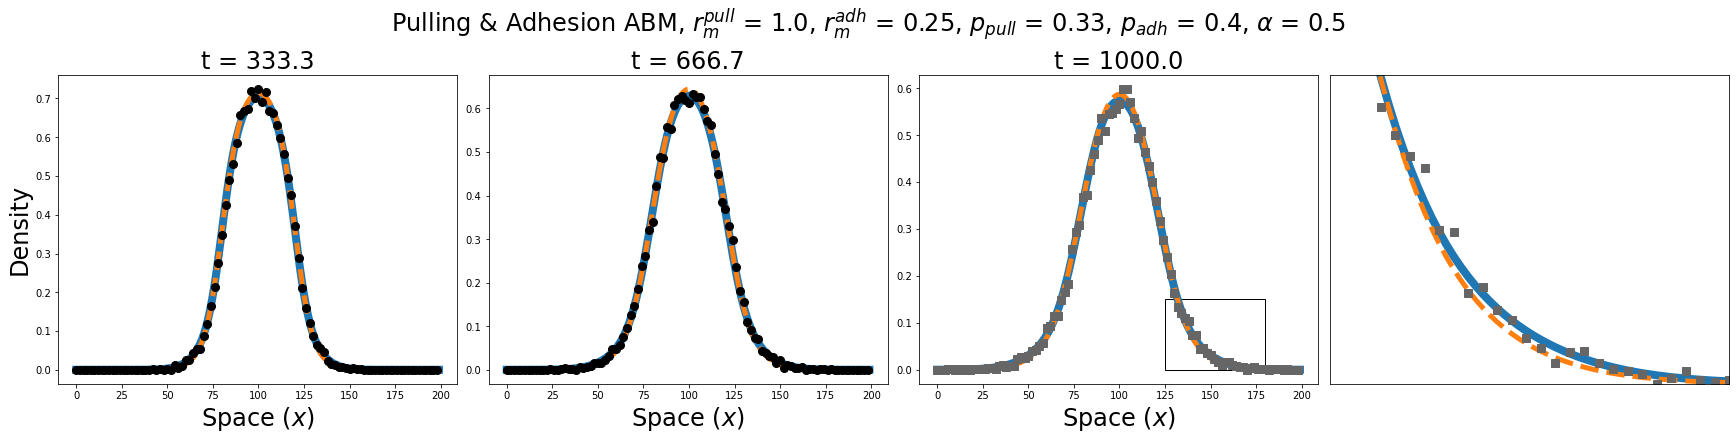

In [7]:
path = '../../data/'

#base parameters
rmh, rmp, Padh, Ppull, alpha = 0.25, 1.0, 0.33, 0.33, 0.5


### Simulation 1
Padh = 0.4
zoom = (125, 0, 180-125,  .15)

### Simulation 2
#rmh = 0.1
#zoom = (85, .55, 30,  .1)

params = (rmp, rmh, Ppull, Padh, alpha)

filename_header = f"adhesion_pulling_mean_25"

### BINN model information
save_folder = "../../results/weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

file_name = f'{filename_header}_PmH_{rmh}_PmP_{rmp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}' 

### load in ABM data
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
outputs = outputs.reshape(shape)
x = np.unique(inputs[:,0])
t = np.unique(inputs[:,1])
IC_mat = np.load(path+file_name+".npy",allow_pickle=True).item()
compartmental_data = IC_mat['compartments']
Hcomp, Pcomp = compartmental_data[0,:,:], compartmental_data[1,:,:]
comp_IC = np.hstack( (Hcomp[:,0], Pcomp[:,0]) )

#load in BINN data
binn_name  = f"{model_name}"
binn_save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
model,binn = load_model(binn_name=binn_name,save_name=save_folder + binn_save_name,x=x,t=t)
D_binn, G_binn = recover_binn_params(binn)

#previously-simulated BINN PDE
mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_{file_name}_pde_weight_10000.0.npy",allow_pickle=True).item()
BINN_PDE = mat['U_sim']


q = [rmh/4, rmp/4, Padh, Ppull]
MF_PDE = DE_sim(x, t, q, comp_IC, [], PDE_type = "two-compartment")

fig, ax = plot_sol_data(x,t,outputs,MF_PDE,BINN_PDE, zoom=zoom,sol_interp=None,filename=f"data_prediction_{file_name}", params=params)

## Adhesion prediction (rmh fixed)

In [20]:
def simulate_interpolant_PDE(params,f):

    """
    Simulate a PDE with interpolated diffusion coefficients based on 
    given parameters and and interpolant, f.

    Parameters:
        params (tuple or float): Model parameters, including Adhesion agentmigration `rmh`
                        and adhesion strength `Padh`.
        f (callable): A function that provides interpolated diffusion coefficients based on time and parameters.

    Returns:
        np.ndarray: Spatial grid points `x`.
        np.ndarray: Time points `t`.
        np.ndarray: The solution of the PDE system with interpolated diffusion.
        np.ndarray: The original data for comparison.
    """
    
    if len(params)==1: #only changing Padh
        rmh = 1.0
        Padh = params[0]
    else: #changing rmh and Padh
        rmh, Padh = params
    
    #Define function of T for numerical integration
    def interpolated_diffusion(T):
        
        ### Create [T;params]
        param_mesh = matlib.repmat(params,len(T),1)
        sampled_points_mesh = np.hstack([T[:,None], param_mesh])
        ### Compute D(T;params)
        D_mesh = f(sampled_points_mesh)
        ### Set any negative values to zero
        D_mesh[D_mesh < 0] = 0
        
        return D_mesh

    ### Load in ABM data
    file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}' 
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
    x,t = unique_inputs(inputs)
    U = outputs.reshape((len(x),-1))
    #Use first timeshot for initial condition
    IC = U[:,0]
    
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)
    
    return x, t, sol, U

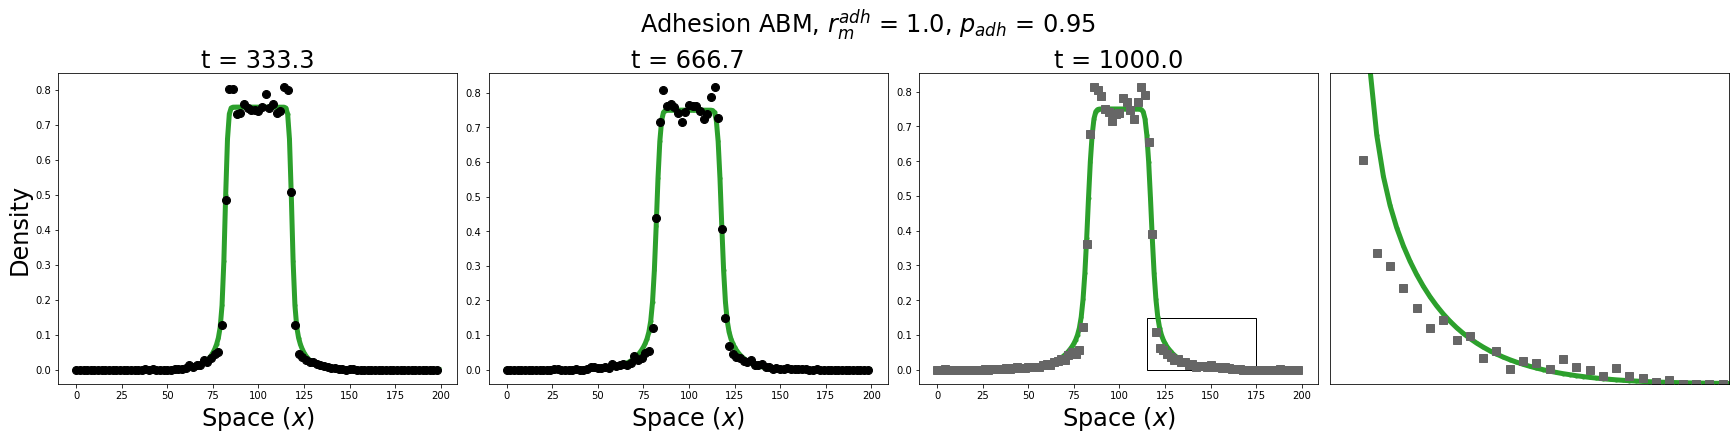

In [8]:
T_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_interpolant_Pm_fixed.npy",allow_pickle=True).item()
f = mat['f']

Padh = 0.95
rmh = 1.0
zoom = (115, 0, 60,  .15)

params = (Padh)
params_title = (rmh,Padh)

def interpolated_diffusion(T):

    param_mesh = matlib.repmat(params,len(T),1)
    sampled_points_mesh = np.hstack([T[:,None], param_mesh])
    D_mesh = f(sampled_points_mesh)
    D_mesh[D_mesh < 0] = 0

    return D_mesh

filename_header = f"simple_adhesion_mean_25"
file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}' 
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,zoom=zoom,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)

## Adhesion prediction (over rmh and padh)

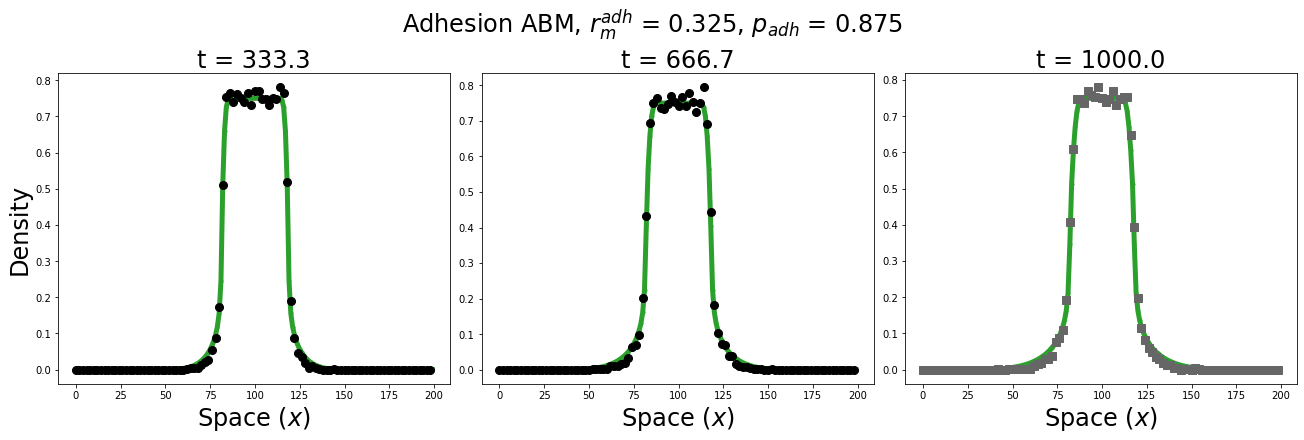

In [9]:
T_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_interpolant.npy",allow_pickle=True).item()
f = mat['f']

### Simulation 1
#rmh = 0.595
#Padh = 0.975
#zoom = None

### Simulation 2
rmh = 0.325
Padh = 0.875
zoom = None

params = (rmh,Padh)
params_title = (rmh,Padh)

def interpolated_diffusion(T):

    param_mesh = matlib.repmat(params,len(T),1)
    sampled_points_mesh = np.hstack([T[:,None], param_mesh])
    D_mesh = f(sampled_points_mesh)
    D_mesh[D_mesh < 0] = 0

    return D_mesh

filename_header = f"simple_adhesion_mean_25"
file_name = f'{filename_header}_Pm_{rmh}_Padh_{Padh}' 
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,zoom=zoom,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)

## Pulling & Adhesion prediction

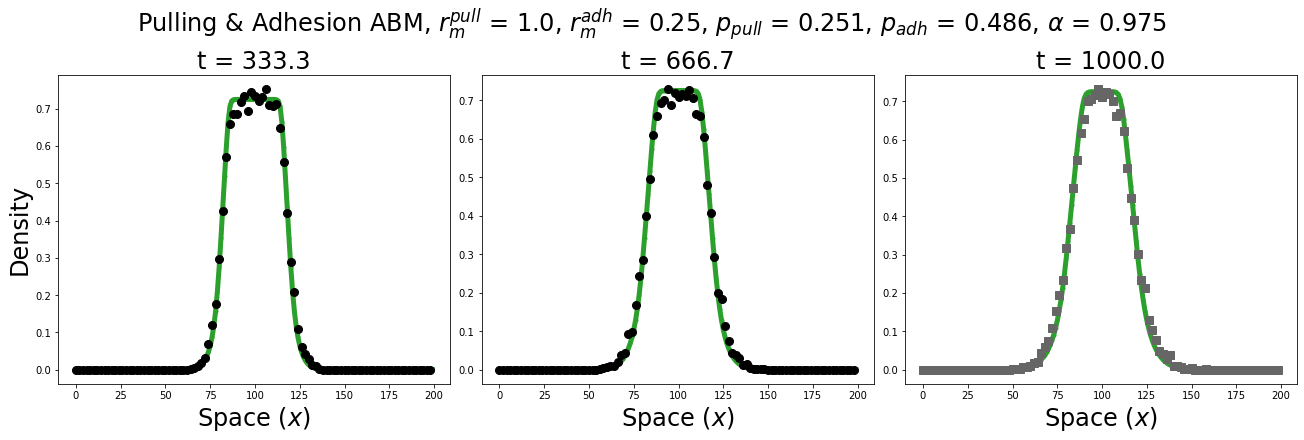

In [27]:
u_mesh = np.linspace(0, 1, 101)[:,None]
path = '../../data/'
mat = np.load("../../results/PDE_sims/adhesion_pulling_interpolant.npy",allow_pickle=True).item()
f = mat['f']

params_new = np.round(get_heterog_LHC_params("Testing"),3)

### Simulation 1
#param_index = 6 #worst ABM prediction result

### Simulation 2
param_index = 5 #4th-worst ABM prediction result

params = params_new[param_index]
rmh, rmp, Padh, Ppull, alpha = params

params_title = (rmp, rmh, Ppull, Padh, alpha)

def interpolated_diffusion(T):

    param_mesh = matlib.repmat(params,len(T),1)
    sampled_points_mesh = np.hstack([T[:,None], param_mesh])
    D_mesh = f(sampled_points_mesh)
    D_mesh[D_mesh < 0] = 0

    return D_mesh

file_name = f'adhesion_pulling_mean_25_PmH_{rmh}_PmP_{rmp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

x,t = unique_inputs(inputs)

outputs = outputs.reshape((len(x),-1))
IC = outputs[:,0]

sol = DE_sim(x, 
             t, 
             [], 
             IC, 
             Diffusion_function = interpolated_diffusion)

fig, ax = plot_sol_data(x,t,outputs,sol_interp = sol, filename=f"data_prediction_{file_name}", params = params_title)